In [ ]:
!pip install -U numexpr copulas
!pip install umap-learn

In [4]:

import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import warnings
from scipy.stats import lognorm

# we use google drive here, change as needed.
from google.colab import drive
drive.mount('/content/drive')

# Suppress warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [5]:
import os
# Change to your preferred dir
os.chdir('/content/drive/MyDrive/TrainSynthDataGeneration')

In [9]:
import pandas as pd
import numpy as np
import time
from concurrent.futures import ThreadPoolExecutor
from copulas.multivariate import GaussianMultivariate
import warnings
import os
from datetime import timedelta
from random import uniform
from scipy.stats import lognorm
import pickle
from tqdm.notebook import tqdm, trange

columns_to_generate = [
    'Durata', 'CabEnabled_M1', 'CabEnabled_M8', 'ERTMS_PiastraSts', 'HMI_ACPntSts_T2', 'HMI_ACPntSts_T7',
    'HMI_DCPntSts_T2', 'HMI_DCPntSts_T7', 'HMI_Iline', 'HMI_Irsts_T2', 'HMI_Irsts_T7', 'HMI_VBatt_T2',
    'HMI_VBatt_T4', 'HMI_VBatt_T5', 'HMI_VBatt_T7', 'HMI_Vline', 'HMI_impSIL', 'LineVoltType', 'MDS_LedLimVel',
    'MDS_StatoMarcia', '_GPS_LAT', '_GPS_LON', 'ldvvelimps', 'ldvveltreno', 'usB1BCilPres_M1', 'usB1BCilPres_M3',
    'usB1BCilPres_M6', 'usB1BCilPres_M8', 'usB1BCilPres_T2', 'usB1BCilPres_T4', 'usB1BCilPres_T5', 'usB1BCilPres_T7',
    'usB2BCilPres_M1', 'usB2BCilPres_M3', 'usB2BCilPres_M6', 'usB2BCilPres_M8', 'usB2BCilPres_T2', 'usB2BCilPres_T4',
    'usB2BCilPres_T5', 'usB2BCilPres_T7', 'usBpPres', 'usMpPres'
]

all_columns = [
    'Flotta', 'Veicolo', 'Codice', 'Nome', 'Descrizione', 'Test', 'Timestamp', 'Timestamp chiusura', 'Durata',
    'Posizione', 'Sistema', 'Componente', 'Latitudine', 'Longitudine', 'Contemporaneo', 'Timestamp segnale'
] + columns_to_generate

#+ ['Tipo_Evento', 'Tipo_Evento_Classificato']


timestamp_iniziale = pd.Timestamp.now()

df_originale = pd.read_csv('dataset_cleaned.csv') # these data are private. Contact the correspondence author for more info.
#df_anomalie = df_originale[df_originale['Tipo_Evento'] == 'Anomalia']
#df_normali = df_originale[df_originale['Tipo_Evento'] == 'Funzionamento Normale']

columns_to_check = ['Descrizione', 'Timestamp', 'Codice', 'Nome']

"""
Rimuove duplicati basandosi su colonne chiave. Se due righe consecutive hanno stessi Timestamp, Descrizione, Nome ecc.,
vengono eliminate (sono ripetizioni). Questo migliora la qualità statistica dei dati che verranno usati per generazione.
"""
df_deduplicate_completo = df_originale.loc[(df_originale[columns_to_check] != df_originale[columns_to_check].shift()).any(axis=1)]
df_completo = df_deduplicate_completo[columns_to_generate]
# we ain't gonna generate duratas
df_completo_gen = df_completo.drop(columns=['Durata'])


print(f"Numero di elementi: {len(df_completo)}")


Numero di elementi: 4026


In [19]:
len(all_columns)

58

# Single copula version:

          x         y
0 -0.598120 -1.195384
1  0.366851  0.733803
2 -0.275781 -0.551368
3 -0.582574 -1.166890
4 -0.002311 -0.004391


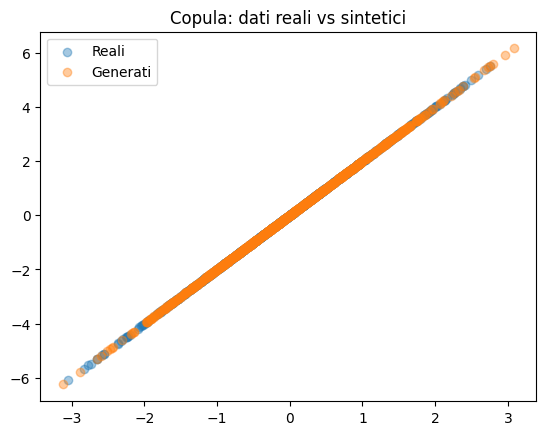

In [ ]:
#esempio di copula:apprendimento
import pandas as pd
import numpy as np
from copulas.multivariate import GaussianMultivariate

# Creiamo un dataset semplice
np.random.seed(0)
x = np.random.normal(0, 1, 1000)
y = 2 * x  # y fortemente correlato a x

df = pd.DataFrame({'x': x, 'y': y})

# Alleniamo la copula
copula = GaussianMultivariate()
copula.fit(df)

# Generiamo nuovi dati
df_fake = copula.sample(1000)
print(df_fake[:5])

# Confrontiamo
import matplotlib.pyplot as plt

plt.scatter(df['x'], df['y'], alpha=0.4, label='Reali')
plt.scatter(df_fake['x'], df_fake['y'], alpha=0.4, label='Generati')
plt.legend()
plt.title("Copula: dati reali vs sintetici")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# ============ PASSO 1: DATI REALI SEMPLIFICATI ============
np.random.seed(42)
n_samples = 1000

# Generiamo 3 sensori correlati (come nel mondo reale)
# Voltaggio batteria (V)
voltaggio = np.random.normal(25, 2, n_samples)  # Media 25V, deviazione 2V

# Pressione freni (bar) - correlata al voltaggio
# Se voltaggio basso → pressione freni problematica
pressione = 5 + 0.3 * voltaggio + np.random.normal(0, 0.5, n_samples)

# Velocità (km/h) - correlata a entrambi
# Se voltaggio OK e pressione OK → velocità normale
velocita = 80 + 0.5 * voltaggio + 2 * pressione + np.random.normal(0, 3, n_samples)

# Creiamo il dataset
dati_reali = pd.DataFrame({
    'voltaggio': voltaggio,
    'pressione': pressione,
    'velocita': velocita
})

print("=== DATI REALI ===")
print(dati_reali.head())
print("\nCorrelazioni nei dati reali:")
print(dati_reali.corr().round(3))

# ============ PASSO 2: LA COPULA IMPARA ============
print("\n=== COSA FA LA COPULA ===")

# A) Trasforma ogni colonna in valori uniformi [0,1]
from scipy.stats import rankdata

def to_uniform(data):
    """Trasforma i dati in distribuzione uniforme [0,1]"""
    ranks = rankdata(data)
    return (ranks - 1) / (len(data) - 1)

# Trasformazione in uniformi
u_voltaggio = to_uniform(dati_reali['voltaggio'])
u_pressione = to_uniform(dati_reali['pressione'])
u_velocita = to_uniform(dati_reali['velocita'])

uniformi = pd.DataFrame({
    'u_voltaggio': u_voltaggio,
    'u_pressione': u_pressione,
    'u_velocita': u_velocita
})

print("Dati trasformati in uniformi [0,1]:")
print(uniformi.head())
print("\nCorrelazioni mantenute:")
print(uniformi.corr().round(3))

# B) La copula impara la struttura di correlazione
print("\n=== LA COPULA IMPARA LA STRUTTURA ===")
print("1. Prende i valori uniformi")
print("2. Impara: se voltaggio è al 20% → pressione sarà circa al 15%")
print("3. Impara: se voltaggio è al 80% → pressione sarà circa al 85%")
print("4. Memorizza tutte queste 'regole' di correlazione")

# ============ PASSO 3: LA COPULA GENERA NUOVI DATI ============
print("\n=== GENERAZIONE NUOVI DATI ===")

# Simuliamo la generazione (versione semplificata)
np.random.seed(123)
n_new = 100

# 1) Genera correlazioni usando la struttura imparata
# (In realtà la copula gaussiana fa questo in modo più sofisticato)
mean_corr = [0, 0, 0]
cov_matrix = uniformi.cov().values

# Genera nuovi valori uniformi correlati
new_uniform = np.random.multivariate_normal(mean_corr, cov_matrix, n_new)

# Normalizza per avere valori in [0,1]
from scipy.stats import norm
new_uniform = norm.cdf(new_uniform)

# 2) Riconverte in valori reali usando le distribuzioni marginali originali
def from_uniform_to_original(u_values, original_data):
    """Riconverte da uniforme ai valori originali"""
    sorted_original = np.sort(original_data)
    indices = (u_values * (len(sorted_original) - 1)).astype(int)
    return sorted_original[indices]

new_voltaggio = from_uniform_to_original(new_uniform[:, 0], dati_reali['voltaggio'])
new_pressione = from_uniform_to_original(new_uniform[:, 1], dati_reali['pressione'])
new_velocita = from_uniform_to_original(new_uniform[:, 2], dati_reali['velocita'])

dati_sintetici = pd.DataFrame({
    'voltaggio': new_voltaggio,
    'pressione': new_pressione,
    'velocita': new_velocita
})

print("Nuovi dati sintetici generati:")
print(dati_sintetici.head())
print("\nCorrelazioni nei dati sintetici:")
print(dati_sintetici.corr().round(3))

# ============ CONFRONTO ============
print("\n=== CONFRONTO REALI vs SINTETICI ===")
print("Medie:")
print(f"Reali:     {dati_reali.mean().round(2).values}")
print(f"Sintetici: {dati_sintetici.mean().round(2).values}")

print("\nCorrelazioni:")
print("Reali:")
print(dati_reali.corr().round(3))
print("Sintetici:")
print(dati_sintetici.corr().round(3))

# ============ VISUALIZZAZIONE ============
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Grafico 1: Dati reali
axes[0].scatter(dati_reali['voltaggio'], dati_reali['pressione'], alpha=0.6, s=20)
axes[0].set_xlabel('Voltaggio (V)')
axes[0].set_ylabel('Pressione (bar)')
axes[0].set_title('Dati Reali')
axes[0].grid(True, alpha=0.3)

# Grafico 2: Dati sintetici
axes[1].scatter(dati_sintetici['voltaggio'], dati_sintetici['pressione'], alpha=0.6, s=20, color='red')
axes[1].set_xlabel('Voltaggio (V)')
axes[1].set_ylabel('Pressione (bar)')
axes[1].set_title('Dati Sintetici')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== RIASSUNTO ===")
print("La copula ha:")
print("1. ✅ Mantenuto le correlazioni originali")
print("2. ✅ Preservato le distribuzioni marginali")
print("3. ✅ Generato dati realistici")
print("4. ✅ Permesso di creare nuovi campioni 'verosimili'")

In [ ]:
#Fitta una copula gaussiana su tutti i dati anomalia
file_anomalie = 'dataset_sintetico_anomalie.csv'
file_normali = 'dataset_sintetico_normali.csv'
num_righe = 1000

warnings.filterwarnings("ignore", category=RuntimeWarning)

df_anomalie_copula = df_anomalie.drop(columns=['Durata'], errors='ignore')
df_normali_copula = df_normali.drop(columns=['Durata'], errors='ignore')

copula_anomalie = GaussianMultivariate()
copula_anomalie.fit(df_anomalie_copula)

with open('copula_anomalie.pkl', 'wb') as f:
    pickle.dump(copula_anomalie, f)

copula_normali = GaussianMultivariate()
copula_normali.fit(df_normali_copula)

with open('copula_normali.pkl', 'wb') as f:
    pickle.dump(copula_normali, f)


# Clusterised version:

## Anomalies:

In [ ]:
# Reduce dimensionality using UMAP
complete_reducer = umap.UMAP(n_components=2, random_state=42)  # Adjust n_components if needed
embedding = complete_reducer.fit_transform(df_completo_gen)

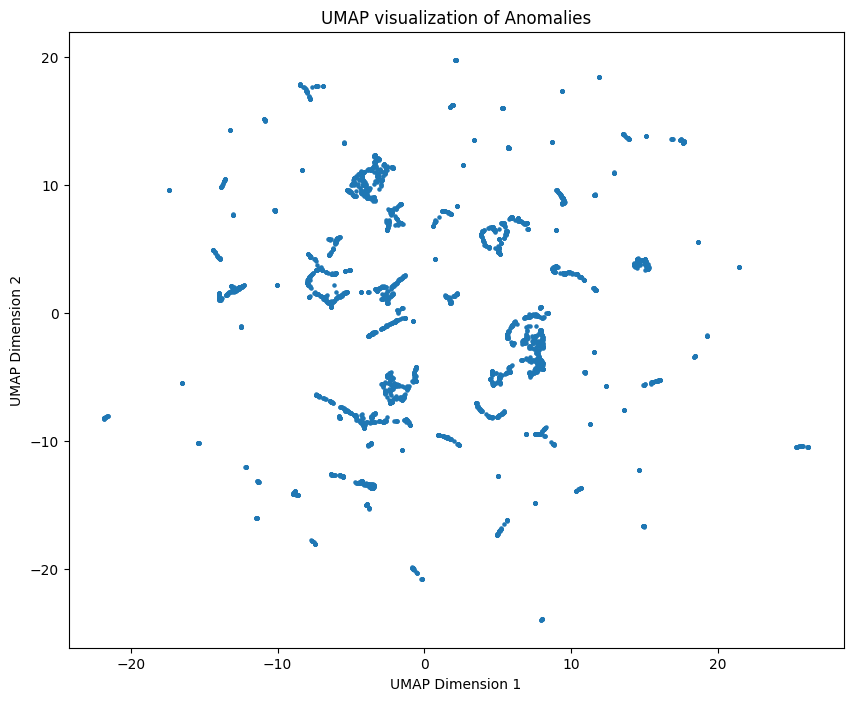

In [ ]:
# Visualize data
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5) # Adjust 's' for point size
plt.title('UMAP visualization of Anomalies')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [1]:
# Define a range of epsilon values to test
eps_values = np.linspace(0.1, 5, 20)  # Adjust the range as needed

best_eps = 0
best_score = -1

for eps in eps_values:
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=3) # Adjust min_samples as needed
    clusters = dbscan.fit_predict(embedding)

    # Calculate the silhouette score (or other metrics)
    if len(set(clusters)) > 1:  # Need at least two clusters for silhouette score
        score = silhouette_score(embedding, clusters)

        # Update best parameters if current score is better
        if score > best_score and clusters.max() < 20:
            print(eps, score)
            best_score = score
            best_eps = eps

# Perform DBSCAN clustering with the best epsilon value
dbscan = DBSCAN(eps=best_eps, min_samples=5)
df_completo_gen['cluster'] = dbscan.fit_predict(embedding)

# Print the best parameters and score
print(f"Best epsilon: {best_eps}")
print(f"Best silhouette score: {best_score}")

NameError: name 'np' is not defined

In [ ]:
np.unique(df_completo_gen['cluster'])

array([0, 1, 2, 3, 4])

In [ ]:
cluster_counts = df_completo_gen['cluster'].value_counts()
probabilities = cluster_counts / cluster_counts.sum()
probabilities = probabilities.sort_index()
probabilities = pd.DataFrame(probabilities).reset_index()
probabilities.columns = ['cluster','probability']
probabilities.to_csv('complete_cluster_probabilities.csv', header=True, index=False)
pd.read_csv('anomaly_cluster_probabilities.csv')['probability'].sum()

np.float64(0.9999999999999998)

In [ ]:
probabilities

,cluster,probability
0,0,0.970194
1,1,0.006955
2,2,0.008693
3,3,0.004968
4,4,0.009190


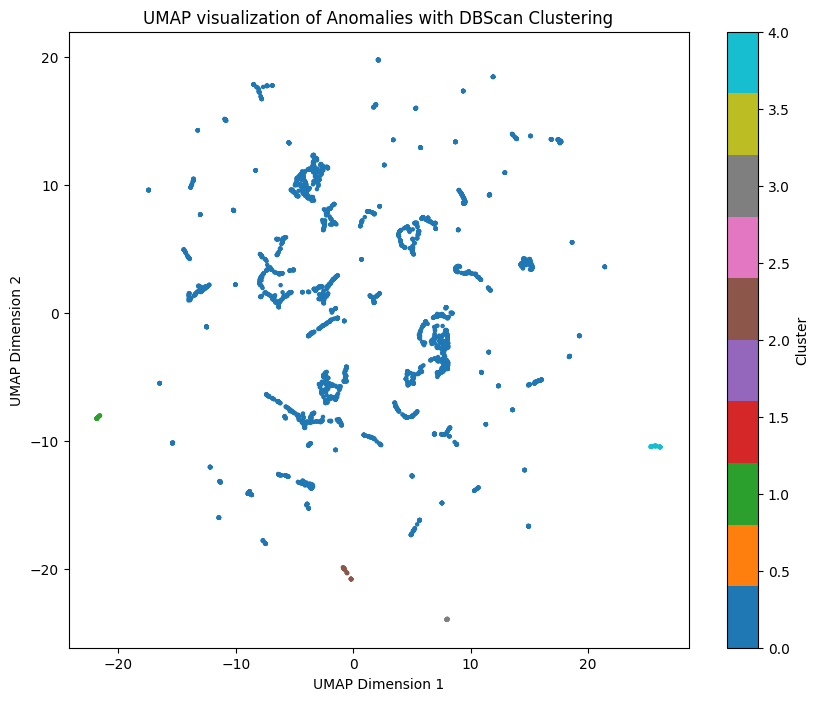

In [ ]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df_completo_gen['cluster'], cmap='tab10', s=5) # Adjust 's' for point size
plt.colorbar(label='Cluster')
plt.title('UMAP visualization of Anomalies with DBScan Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
"""
Scorre tutti i numeri di cluster trovati,
Estrae il sotto-dataset del cluster corrente,
Allena una copula su quel gruppo specifico
"""
cluster_dataframes = {}
cluster_generators = {}
for cluster_num in df_completo_gen['cluster'].unique():
  print(cluster_num)
  cluster_df = df_completo_gen[df_completo_gen['cluster'] == cluster_num].drop(columns=['cluster'])
  cluster_dataframes[cluster_num] = cluster_df
  cluster_generators[cluster_num] = GaussianMultivariate()
  cluster_generators[cluster_num].fit(cluster_df)
  with open(f'copula_complete_cluster_{cluster_num}.pkl', 'wb') as f:
    pickle.dump(cluster_generators[cluster_num], f)

0
1
2
3
4


## Reading the anomaly generators:

In [ ]:
generators = {}
for i in range(20): # Assuming you have 20 clusters
    try:
        with open(f'copula_complete_cluster_{i}.pkl', 'rb') as f:
            generators[i] = pickle.load(f)
        print(f"Successfully loaded generator for cluster {i}")
    except FileNotFoundError:
        print(f"Generator file for cluster {i} not found.")

Successfully loaded generator for cluster 0
Successfully loaded generator for cluster 1
Successfully loaded generator for cluster 2
Successfully loaded generator for cluster 3
Successfully loaded generator for cluster 4
Generator file for cluster 5 not found.
Generator file for cluster 6 not found.
Generator file for cluster 7 not found.
Generator file for cluster 8 not found.
Generator file for cluster 9 not found.
Generator file for cluster 10 not found.
Generator file for cluster 11 not found.
Generator file for cluster 12 not found.
Generator file for cluster 13 not found.
Generator file for cluster 14 not found.
Generator file for cluster 15 not found.
Generator file for cluster 16 not found.
Generator file for cluster 17 not found.
Generator file for cluster 18 not found.
Generator file for cluster 19 not found.


In [ ]:
complete_probabilities = pd.read_csv('complete_cluster_probabilities.csv')

In [ ]:
alpha = 0.2
beta = 1.9
mu_anomalies = 0.157
media_durata_anomalie = mu_anomalies * alpha
sigma_anomalie = 1 * beta
lognormal_anomalie = lognorm(s=sigma_anomalie, scale=np.exp(np.log(media_durata_anomalie)))

In [ ]:
generated_records = []
for cluster in generators:
  #anomaly probabilities
  probability = complete_probabilities[complete_probabilities['cluster'] == cluster]['probability'].values[0]
  print(probability)
  #Calcola quante righe generare per quel cluster ,ad esempio, se il cluster ha 0.15 di probabilità → 0.15 * 2000 = 300 righe.
  samples_to_produce = int(probability * 2000)
  print(f'Cluster {cluster} will produce {samples_to_produce} samples')
  #chiama il generatore del cluster anomalia x e produce n righe a cui va aggiungere delle colonne
  cluster_records = generators[cluster].sample(samples_to_produce)
  # append dummy cols:
  cluster_records['Durata'] = 0.0
  cluster_records['Flotta'] = 0.0
  cluster_records['Veicolo'] = 0.0
  cluster_records['Test'] = 0.0
  cluster_records['Timestamp'] = 0.0
  cluster_records['Timestamp chiusura'] = 0.0
  cluster_records['Posizione'] = 0.0
  cluster_records['Sistema'] = 0.0
  cluster_records['Componente'] = 0.0
  cluster_records['Timestamp segnale'] = 0.0
  # more dummy cols:
  for dummy_col in ['Codice', 'Nome', 'Descrizione', 'Latitudine', 'Longitudine', 'Contemporaneo', 'Tipo_Evento', 'Tipo_Evento_Classificato']:
    cluster_records[dummy_col] = 0.0
  # append a column with the cluster index:
  cluster_records['cluster'] = cluster
  generated_records.append(cluster_records)

0.970193740685544
Cluster 0 will produce 1940 samples
0.0069547938400397
Cluster 1 will produce 13 samples
0.0086934923000496
Cluster 2 will produce 17 samples
0.0049677098857426
Cluster 3 will produce 9 samples
0.0091902632886239
Cluster 4 will produce 18 samples


In [ ]:
"""
Serve a verificare che le colonne generate (escludendo "Durata") siano esattamente quelle usate per allenare la copula.
 Se questa condizione è True, allora puoi stare tranquillo che il dataset sintetico ha la stessa forma del dataset reale in input
"""
synthetic_records_df = pd.concat(generated_records)
synthetic_records_df['class'] = 'Anomaly'
synthetic_records_df['Durata'] = lognormal_anomalie.rvs(size=len(synthetic_anomaly_records_df))

In [ ]:
syntetic_records_df[columns_to_generate].drop(columns='Durata').columns == df_complete_gen.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

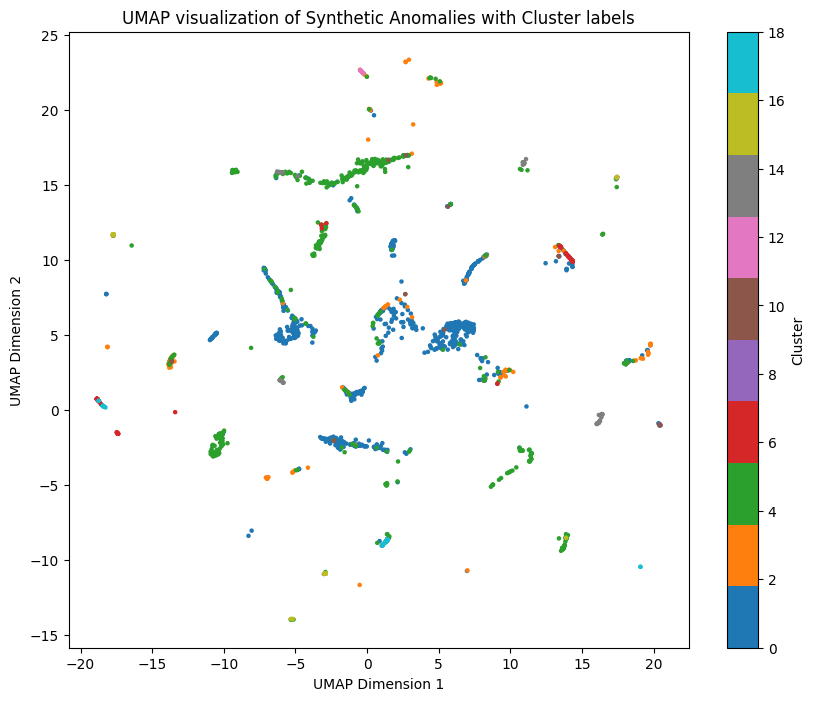

In [ ]:
# Reduce dimensionality using UMAP
embedding = complete_reducer.transform(synthetic_anomaly_records_df[columns_to_generate].drop(columns='Durata'))
# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=synthetic_records_df['cluster'], cmap='tab10', s=5) # Adjust 's' for point size
plt.colorbar(label='Cluster')
plt.title('UMAP visualization of Synthetic Generated data with Cluster labels')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [32]:
#gan no conditional
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import wandb

# --------------------
# PARAMETRI
# --------------------
batch_size = 64
latent_dim = 1
cond_dim = 1    #dimensione condizione:1 , è un vettore di label 0/1
num_epochs = 2500
G_lr = 0.01  # Learning rate più alto per il generatore: in precedenti operazioni il discriminatore imparava troppo velocemente rispetto al generatore
D_lr = 0.001  # Learning rate più basso per il discriminatore
lambda_reg_x = 1.0  # Regolarizzazione per param_x
lambda_reg_label = 2.0 # Regolarizzazione per param_y_if_0
lambda_reg_bias = 2.0  # Regolarizzazione per param_y_if_1
n_critic=5



print(len(df_originale[columns_to_generate].columns))


train_dl = DataLoader(df_originale[columns_to_generate], batch_size=batch_size, shuffle=True)


# --------------------
# MODELLI CONDITIONAL GAN
# --------------------

#da 100 latent dimension a 42 dimension : columns to generate
class Generator_Net(nn.Module):
    def __init__(self, latent_dim, output_dim=42):
        super(Generator_Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()  # oppure Sigmoid o nessuna attivazione a seconda della normalizzazione dei dati
        )

    def forward(self, z):
        return self.model(z)

class Discriminator_Net(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator_Net, self).__init__()
        self.model = nn.Sequential(
            #42 feature di input da generare
            nn.Linear(42, 128),  # Aumentato neuroni
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid() #valore compreso tra 0 ed 1 , verosimiglianza del dato
        )

    def forward(self, x ):
        #x 42 feature
        return self.model(x)

# --------------------
# ISTANZIAZIONE
# --------------------
G_model = Generator_Net(100)
D_model = Discriminator_Net(input_dim=42)  # 42 feature
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_model = G_model.to(device)
D_model = D_model.to(device)

D_loss_fn = nn.BCELoss()
G_opt = optim.Adam(G_model.parameters(), lr=G_lr)
D_opt = optim.Adam(D_model.parameters(), lr=D_lr)
print([named_param[0] for named_param in G_model.named_parameters()])
print([named_param[0] for named_param in D_model.named_parameters()])



42
['model.0.weight', 'model.0.bias', 'model.2.weight', 'model.2.bias', 'model.4.weight', 'model.4.bias']
['model.0.weight', 'model.0.bias', 'model.3.weight', 'model.3.bias', 'model.6.weight', 'model.6.bias']


In [ ]:

# --------------------
# LOGGING & TRAINING
# --------------------


list_losses_real = []
list_losses_fake = []
list_losses_tricked = []
param_x = []
param_label= []
param_bias = []

for epoch in range(num_epochs):
    for i,xb_batch in enumerate(train_dl): #xb_batch è un contenitore di 64 tuple del dataset originale (in ordine casuale)
        real_data = xb_batch[0].to(device) #estrae le 64 tuple dal batch
        batch_size_curr = real_data.size(0) #numero tuple (64)
        conditions = real_data[:, 0:1]  # Estrae flag
        data_xy = real_data[:, 1:]      # Estrae [x, y]
        real_labels = torch.ones((batch_size_curr, 1)).to(device)
        fake_labels = torch.zeros((batch_size_curr, 1)).to(device)


        if i % n_critic == 0:
           # D step
          D_model.train()
          G_model.eval()
          #una sola volta
          D_opt.zero_grad()
          #DATI REALI
          #struttura discriminatore(flag,tupla_xy): concatena conditions e data_xy , passa attraverso architettura e ritorna un sigmoide(valore di verosimiglianza)
          output_real = D_model(conditions, data_xy)
          D_real_loss = D_loss_fn(output_real, real_labels)

          #DATI FAKE
          noise_labels = torch.randint(0, 2, (batch_size_curr, 1)).float().to(device)
          noise_x = torch.randint(-1, 1, (batch_size_curr, 1)).float().to(device)
          noise_input = torch.cat((noise_labels, noise_x), dim=1)
          #struttura generatore(flag,x) calcola y e concatena flag,x,y
          fake_data = G_model(noise_input).detach()

          #struttura discriminatore(flag,tupla_xy): concatena conditions e data_xy , passa attraverso architettura e ritorna un sigmoide(valore di verosimiglianza)
          output_fake = D_model(fake_data[:,0].unsqueeze(1),fake_data[:, 1:])  # Usa solo [x, y] e non la labels
          D_fake_loss = D_loss_fn(output_fake, fake_labels)
          #Una sola backward per il discriminatore
          D_total_loss = D_real_loss + D_fake_loss
          D_total_loss.backward()
          D_opt.step()

        # G step
        G_model.train()
        D_model.eval()
        G_opt.zero_grad()
        # Rigenera noise_input con la dimensione batch corretta e spostalo su device

        # G step - generazione del noise correttamente scalato dopo il .float().to(device)
        noise_labels = torch.randint(0, 2, (batch_size_curr, 1)).float().to(device)  # [0,1] -> float
        noise_x = torch.randint(0, 101, (batch_size_curr, 1)).float().to(device)  # [1,100] -> float
        noise_x = noise_x / 50.0 - 1  # scala da [1,100] -> [-1,1]
        if epoch==0 or epoch==200:
            print(f"noise_x: {noise_x[5 , :]}")
        noise_input = torch.cat((noise_labels, noise_x), dim=1)
        #struttura generatore(flag,x) calcola y e concatena flag,x,y
        fake_data = G_model(noise_input)
        output_trick = D_model( fake_data[:,0].unsqueeze(1),fake_data[:, 1:])
        G_loss = D_loss_fn(output_trick, real_labels)

        # Regolarizzazione
      #  reg_loss_x = lambda_reg_x * (G_model.param_x - 1.0) ** 2
        reg_loss_bias = lambda_reg_label * (G_model.param_bias - 50.0) ** 2
        reg_loss_label_bias = lambda_reg_bias * ((G_model.param_label + G_model.param_bias) - 100.0) ** 2
        total_G_loss = G_loss + reg_loss_bias + reg_loss_label_bias

       # total_G_loss.backward()
        G_loss.backward()
        #torch.nn.utils.clip_grad_norm_(G_model.parameters(), max_norm=1.0)
        G_opt.step()

        # Logging
        if epoch % 100 == 0:
            list_losses_real.append(D_real_loss.item())
            list_losses_fake.append(D_fake_loss.item())
            list_losses_tricked.append(G_loss.item())
          #  param_x.append(G_model.param_x.item())
            param_label.append(G_model.param_label.item())
            param_bias.append(G_model.param_bias.item())
            run.log({
                "epoch": epoch,
                "D_real_loss": D_real_loss.item(),
                "D_fake_loss": D_fake_loss.item(),
                "G_loss": G_loss.item(),
               # "param_x": G_model.param_x.item(),
                "param_label": G_model.param_label.item(),
                "param_bias": G_model.param_bias.item(),
                "label_plus_bias": (G_model.param_label + G_model.param_bias).item()
            })
            print(f"Epoch {epoch} | D_real={D_real_loss.item():.4f} | D_fake={D_fake_loss.item():.4f} | G_loss={G_loss.item():.4f}")
            print(f"param_label={G_model.param_label.item():.4f} | param_bias={G_model.param_bias.item():.4f} | label+bias={(G_model.param_label + G_model.param_bias).item():.4f}")


run.log_code()
run.finish()

## Normal data:

In [ ]:
# Reduce dimensionality using UMAP
normal_reducer = umap.UMAP(n_components=2, random_state=42)  # Adjust n_components if needed
embedding = normal_reducer.fit_transform(df_normali_gen)

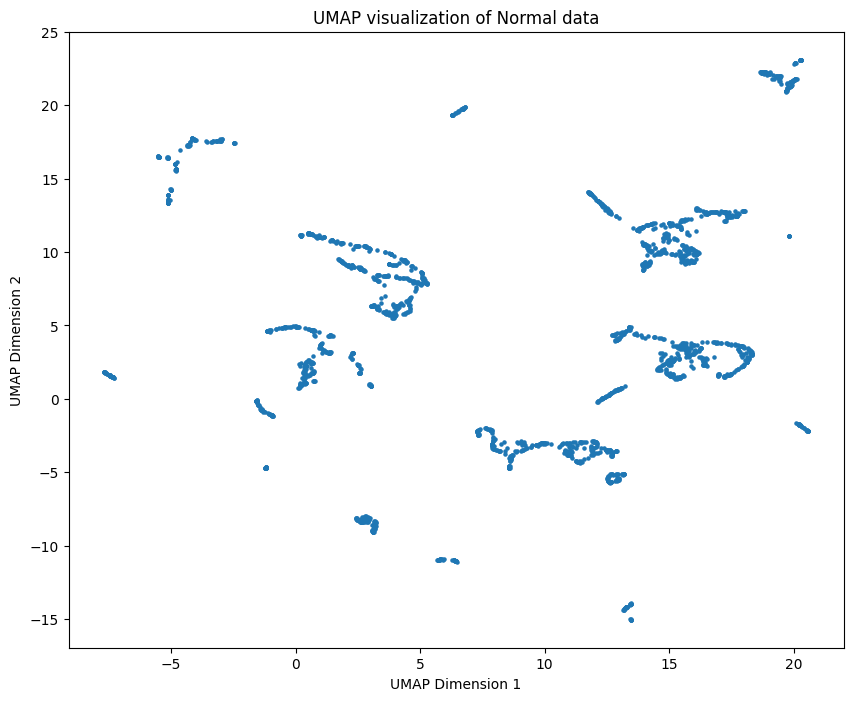

In [ ]:
# Visualize data
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5) # Adjust 's' for point size
plt.title('UMAP visualization of Normal data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Define a range of epsilon values to test
eps_values = np.linspace(0.1, 2, 20)  # Adjust the range as needed

best_eps = 0
best_score = -1

for eps in eps_values:
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=5) # Adjust min_samples as needed
    clusters = dbscan.fit_predict(embedding)

    # Calculate the silhouette score (or other metrics)
    if len(set(clusters)) > 1:  # Need at least two clusters for silhouette score
        score = silhouette_score(embedding, clusters)

        # Update best parameters if current score is better
        if score > best_score:
            best_score = score
            best_eps = eps

# Perform DBSCAN clustering with the best epsilon value
dbscan = DBSCAN(eps=best_eps, min_samples=5)
df_normali_gen['cluster'] = dbscan.fit_predict(embedding)

# Print the best parameters and score
print(f"Best epsilon: {best_eps}")
print(f"Best silhouette score: {best_score}")

Best epsilon: 1.9
Best silhouette score: 0.6180574893951416


In [ ]:
np.unique(df_normali_gen['cluster'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
cluster_counts = df_normali_gen['cluster'].value_counts()
probabilities = cluster_counts / cluster_counts.sum()
probabilities = probabilities.sort_index()
probabilities = pd.DataFrame(probabilities).reset_index()
probabilities.columns = ['cluster','probability']
probabilities.to_csv('diagnostics_cluster_probabilities.csv', header=True, index=False)
pd.read_csv('diagnostics_cluster_probabilities.csv')['probability'].sum()

0.9999999999999994

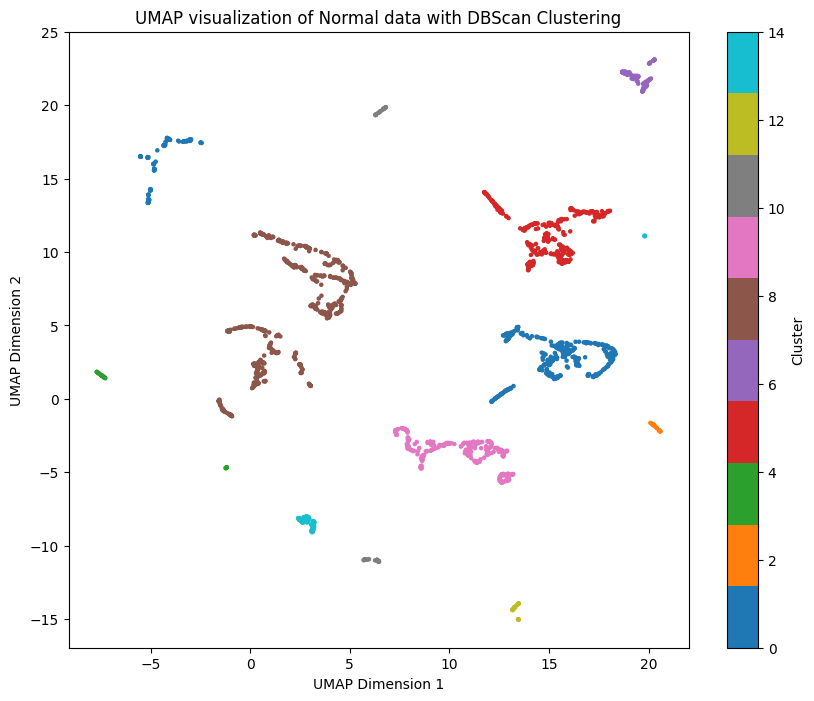

In [ ]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df_normali_gen['cluster'], cmap='tab10', s=5) # Adjust 's' for point size
plt.colorbar(label='Cluster')
plt.title('UMAP visualization of Normal data with DBScan Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [ ]:
normal_cluster_dataframes = {}
normal_cluster_generators = {}
for cluster_num in df_anomalie_gen['cluster'].unique():
  print(cluster_num)
  cluster_df = df_normali_gen[df_normali_gen['cluster'] == cluster_num].drop(columns=['cluster'])
  normal_cluster_dataframes[cluster_num] = cluster_df
  normal_cluster_generators[cluster_num] = GaussianMultivariate()
  normal_cluster_generators[cluster_num].fit(cluster_df)
  with open(f'copula_normal_cluster_{cluster_num}.pkl', 'wb') as f:
    pickle.dump(normal_cluster_generators[cluster_num], f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


## Reading the normal data generators:

In [ ]:
diagnostic_generators = {}
for i in range(15): # Assuming you have 19 clusters
    try:
        with open(f'copula_normal_cluster_{i}.pkl', 'rb') as f:
            diagnostic_generators[i] = pickle.load(f)
        print(f"Successfully loaded generator for cluster {i}")
    except FileNotFoundError:
        print(f"Generator file for cluster {i} not found.")

diagnostic_probabilities = pd.read_csv('diagnostics_cluster_probabilities.csv')

Successfully loaded generator for cluster 0
Successfully loaded generator for cluster 1
Successfully loaded generator for cluster 2
Successfully loaded generator for cluster 3
Successfully loaded generator for cluster 4
Successfully loaded generator for cluster 5
Successfully loaded generator for cluster 6
Successfully loaded generator for cluster 7
Successfully loaded generator for cluster 8
Successfully loaded generator for cluster 9
Successfully loaded generator for cluster 10
Successfully loaded generator for cluster 11
Successfully loaded generator for cluster 12
Successfully loaded generator for cluster 13
Successfully loaded generator for cluster 14


In [ ]:
alpha = 0.2
beta = 1.9
mu_anomalies = 0.157
mu_normal = 0.117
media_durata_normali = mu_normal * alpha
sigma_normali = 1 * beta
lognormal_normali = lognorm(s=sigma_normali, scale=np.exp(np.log(media_durata_normali)))

In [ ]:
generated_diagnostics_records = []
for cluster in diagnostic_generators:
  probability = diagnostic_probabilities[diagnostic_probabilities['cluster'] == cluster]['probability'].values[0]
  samples_to_produce = int(probability * 2000)
  print(f'Cluster {cluster} will produce {samples_to_produce} samples')
  cluster_records = diagnostic_generators[cluster].sample(samples_to_produce)
  # append dummy cols:
  """
  Il tuo generatore (la copula) produce solo un sottoinsieme di colonne: quelle contenute in columns_to_generate, escludendo “Durata”.
  Tuttavia, il tuo dataset originale (cioè quello reale, usato nei modelli downstream, salvato in CSV o usato per addestrare classificatori)
  contiene altre colonne che non sono state generate, ma che devono comunque esistere per mantenere la compatibilità di formato.
  """
  cluster_records['Durata'] = 0.0
  cluster_records['Flotta'] = 0.0
  cluster_records['Veicolo'] = 0.0
  cluster_records['Test'] = 0.0
  cluster_records['Timestamp'] = 0.0
  cluster_records['Timestamp chiusura'] = 0.0
  cluster_records['Posizione'] = 0.0
  cluster_records['Sistema'] = 0.0
  cluster_records['Componente'] = 0.0
  cluster_records['Timestamp segnale'] = 0.0
  # more dummy cols:
  for dummy_col in ['Codice', 'Nome', 'Descrizione', 'Latitudine', 'Longitudine', 'Contemporaneo', 'Tipo_Evento', 'Tipo_Evento_Classificato']:
    cluster_records[dummy_col] = 0.0
  # append a column with the cluster index:
  cluster_records['cluster'] = cluster
  generated_diagnostics_records.append(cluster_records)

synthetic_diagnostics_records_df = pd.concat(generated_diagnostics_records)
synthetic_diagnostics_records_df['class'] = 'Normal'
synthetic_diagnostics_records_df['Durata'] = lognormal_normali.rvs(size=len(synthetic_diagnostics_records_df))

Cluster 0 will produce 353 samples
Cluster 1 will produce 111 samples
Cluster 2 will produce 28 samples
Cluster 3 will produce 30 samples
Cluster 4 will produce 13 samples
Cluster 5 will produce 358 samples
Cluster 6 will produce 95 samples
Cluster 7 will produce 312 samples
Cluster 8 will produce 241 samples
Cluster 9 will produce 296 samples
Cluster 10 will produce 23 samples
Cluster 11 will produce 28 samples
Cluster 12 will produce 29 samples
Cluster 13 will produce 74 samples
Cluster 14 will produce 4 samples


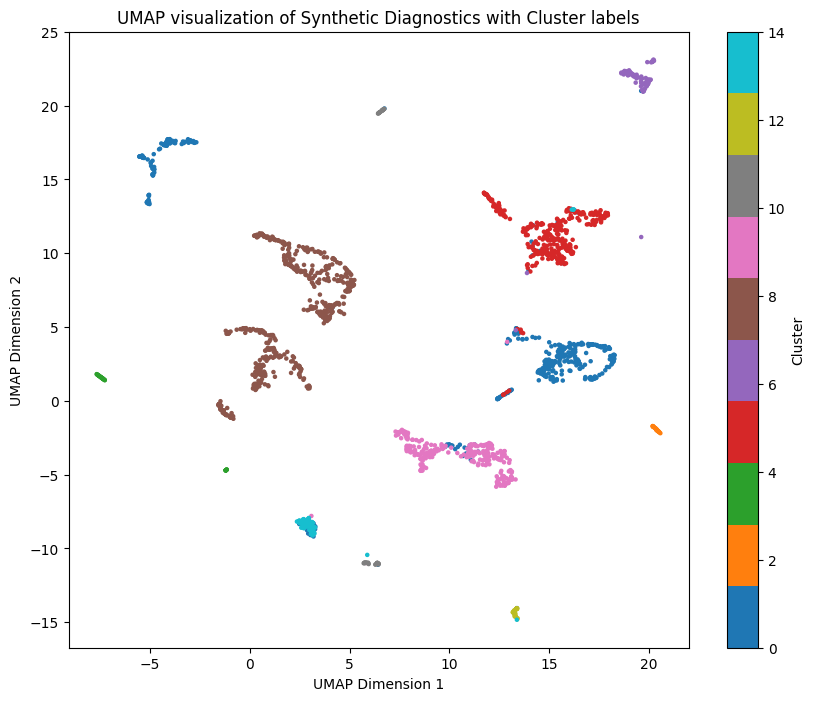

In [ ]:
# Reduce dimensionality using UMAP
embedding = normal_reducer.transform(synthetic_diagnostics_records_df[columns_to_generate].drop(columns=['Durata']))
# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=synthetic_diagnostics_records_df['cluster'], cmap='tab10', s=5) # Adjust 's' for point size
plt.colorbar(label='Cluster')
plt.title('UMAP visualization of Synthetic Diagnostics with Cluster labels')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## Final (bulk) synthetic eval dataset:

In [ ]:
bulk_synth_eval_ds = pd.concat([synthetic_diagnostics_records_df, synthetic_anomaly_records_df])

In [ ]:
# scramble rows if the ds:
bulk_synth_eval_ds = bulk_synth_eval_ds.sample(frac=1).reset_index(drop=True)

In [ ]:
final_col_seq = [
    'Flotta', 'Veicolo', 'Codice', 'Nome', 'Descrizione', 'Test', 'Timestamp',
    'Timestamp chiusura', 'Durata', 'Posizione', 'Sistema', 'Componente', 'Latitudine',
    'Longitudine', 'Contemporaneo', 'Timestamp segnale', 'CabEnabled_M1', 'CabEnabled_M8',
    'ERTMS_PiastraSts', 'HMI_ACPntSts_T2', 'HMI_ACPntSts_T7', 'HMI_DCPntSts_T2', 'HMI_DCPntSts_T7',
    'HMI_Iline', 'HMI_Irsts_T2', 'HMI_Irsts_T7', 'HMI_VBatt_T2', 'HMI_VBatt_T4', 'HMI_VBatt_T5',
    'HMI_VBatt_T7', 'HMI_Vline', 'HMI_impSIL', 'LineVoltType', 'MDS_LedLimVel', 'MDS_StatoMarcia',
    '_GPS_LAT', '_GPS_LON', 'ldvvelimps', 'ldvveltreno', 'usB1BCilPres_M1', 'usB1BCilPres_M3',
    'usB1BCilPres_M6', 'usB1BCilPres_M8', 'usB1BCilPres_T2', 'usB1BCilPres_T4', 'usB1BCilPres_T5', 'usB1BCilPres_T7',
    'usB2BCilPres_M1', 'usB2BCilPres_M3', 'usB2BCilPres_M6', 'usB2BCilPres_M8', 'usB2BCilPres_T2', 'usB2BCilPres_T4',
    'usB2BCilPres_T5', 'usB2BCilPres_T7', 'usBpPres', 'usMpPres', 'Tipo_Evento', 'Tipo_Evento_Classificato', 'cluster', 'class']

In [ ]:
bulk_synth_eval_ds = bulk_synth_eval_ds[final_col_seq]

In [ ]:
bulk_synth_eval_ds.to_csv('final_synth_eval_ds.csv')

In [ ]:
readed_df = pd.read_csv('final_synth_eval_ds.csv', index_col=0)

In [ ]:
readed_df

,Flotta,Veicolo,Codice,Nome,Descrizione,Test,Timestamp,Timestamp chiusura,Durata,Posizione,...,usB2BCilPres_T2,usB2BCilPres_T4,usB2BCilPres_T5,usB2BCilPres_T7,usBpPres,usMpPres,Tipo_Evento,Tipo_Evento_Classificato,cluster,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117804,0.0,...,0.281413,0.088557,0.407447,0.302786,4.973949,8.699815,0.0,0.0,0,Anomaly
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045456,0.0,...,2.270205,2.066576,2.090189,2.399680,3.509778,8.208984,0.0,0.0,7,Anomaly
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024571,0.0,...,-0.328068,-0.260661,-0.690073,0.009995,4.963849,9.014516,0.0,0.0,9,Normal
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031443,0.0,...,0.111979,0.063715,0.144401,0.034471,4.760475,8.479454,0.0,0.0,4,Anomaly
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002516,0.0,...,-0.203479,-0.179288,-0.406835,0.010000,4.991674,9.253624,0.0,0.0,9,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011148,0.0,...,-0.732448,-0.677708,-0.654981,-0.715583,5.672809,8.560523,0.0,0.0,6,Normal
3981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001582,0.0,...,2.010216,1.439072,1.929433,1.748374,3.056627,9.081346,0.0,0.0,4,Anomaly
3982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.469074,0.0,...,0.122580,0.161335,0.095186,0.114716,4.784724,8.559134,0.0,0.0,3,Anomaly
3983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018105,0.0,...,0.516641,0.414415,0.433100,0.435352,4.267296,8.401148,0.0,0.0,7,Normal


In [ ]:
# get 0.99 quantile of each column which
sup_quantiles = readed_df.drop(columns=['cluster','class']).quantile(0.99)

In [ ]:
sup_quantiles

,0.99
Flotta,0.000000
Veicolo,0.000000
Codice,0.000000
Nome,0.000000
Descrizione,0.000000
Test,0.000000
Timestamp,0.000000
Timestamp chiusura,0.000000
Durata,1.905720
Posizione,0.000000


In [ ]:
min_quantiles = readed_df.drop(columns=['cluster','class']).quantile(0.01)

In [ ]:
min_quantiles

,0.01
Flotta,0.000000
Veicolo,0.000000
Codice,0.000000
Nome,0.000000
Descrizione,0.000000
Test,0.000000
Timestamp,0.000000
Timestamp chiusura,0.000000
Durata,0.000308
Posizione,0.000000
